In [1]:
from IPython.display import Image

3장에서는 수집 단계에서 다른 단계로 이동하기 전에 저장되는 메시지 큐 단계를 알아보았다. 여기에 데이터가 쌓여야 가치 있게 활용될 수 있을 것이다. 이제 분석 단계를 알아보자.

# 인플라이트 데이터 분석

데이터에서 **인플라이트(In-flight)** 란 시스템에서 입력(메시지 큐)과 출력, 클라이언트(다음 단계)를 묶은 튜플을 말한다.  

전통적인 DBMS(RDBMS, HADOOP, HBase, Cassandra 등)는 데이터가 정지되어 있고, 얻기 위해 쿼리를 수행한다. 하지만 스트리밍 시스템은 데이터가 지속적으로 들어온다. 이런 모델을 **연속 쿼리 모델(Continuous Query Model)** 이라고 부른다.  

예를 들어 온라인 신문사에서 자신들의 마케팅 캠페인 이슈를 알고 싶다고 하자. 그러면 전통적인 방식은 (1) 사이트에서 데이터 수집 (2) DBMS에 저장 (3) 이슈가 있는 링크 혹인 기사에 대한 쿼리 수행 (4) 데이터 확인 및 대응 (5) 일정 시간마다 쿼리 재수행 과 같다.  

반면, 스트리밍 시스템을 이용하면 (1) 스트림 데이터 수집 (2) 이슈가 잇는 링크 또는 기사에 대한 쿼리 수행 (3) 데이터 확인 및 대응 3단계면 충분하다. 스트리밍 시스템에서 데이터는 지속적으로 pull & push 되어서 시스템 안에서 데이터가 계속 흐르게 된다.

# 분산 스트림 프로세싱 아키텍처

데이터가 어느정도 커지면 1대의 서버에서 감당하기가 힘들다. 따라서 분석 단계를 구축할 때는 분산 시스템이 동반된 기술을 도입해야만 한다.

### 일반적인 아키텍처

Apache Spark, Storm, Flink, Samza 등의 기능들은 다음 3가지 공통점을 가지고 있다.  

- 스트리밍 어플리케이션일 실행된 이후에 hADOOP의 Map-reduce와 유사하게 동작한다. 어플리케이션은 클러스터의 노드들로 전달되어 실행된다.  
- 클러스터를 이루는 개별 노드에서 스트리밍 로직이 실행된다.  
- Raw 데이터는 스트리밍 로직의 입력값으로 들어간다.  

즉 Raw 데이터들이 수집되면 스트림 프로세서에서 로직이 실행되어 스트리밍 매니저로 전달되고, 어플리케이션 드라이버를 통해 스트리밍 어플리케이션과 연동이 된 다음 결과물이 다시 전달되는 방식이다.  

- **어플리케이션 드라이버** : 스트리밍 코드 작성, 스트리밍 매니저와 통신을 위해 어플리케이션 드라이버를 만든다. 드라이버는 스트리밍 매니저에 잡을 등록하고 마지막에 결과를 수집하며 잡의 생명 주기를 관리하는데 활용된다.  
- **스트리밍 매니저** : 스트리밍 잡을 스티리밍 프로세서들로 보내는 역할을 한다.  
- **스트림 프로세서** : 프로세싱이 일어나는 곳으로, 플랫폼에 따라 다른 방식으로 잡이 제출되는 동시에 실행된다.  
- **Raw 데이터** : 스트리밍 잡을 실행하는데 필요한 데이터의 input과 output을 말한다. 

구현하고자 하는 비즈니스 요구사항이 일반적인 아키텍처로 구현이 가능한지 생각해보자. 그리고 다음 3가지 주요 스티리밍 소프트웨어들이 사용하는 내부 아키텍처를 알아보고, 스트림 프로세싱 프레임워크를 선택할 때 고려해야 하는 몇 가지 주요 기능들을 추가로 살펴보자.

### Apache Spark Streaming

아파치 스파크의 기술 스택으로는 다양한 언어(자바, 파이썬, 스칼라, R)를 통한 스파크 스트리밍, MLlib(머신러닝), SparkR(R 언어), GraphX(그래프 프로세싱) 등이 있다.  

스파크 스트리밍의 동작은 기본적으로 배치로 동작한다. 다만 1초도 안되는 일정 시간 범위의 데이터를 배치로 가져와서 지속적으로 반복하면서 데이터를 처리한다. 개발자가 작성한 프로그램을 Streaming Context에서 동작하는데, 흔히 드라이버라고도 부른다.  드라이버는 데이터 입력을 지속적으로 추적하고 스트리밍 잡을 spark worker에 배포하는 역할을 한다. spark worker는 각자 받은 스트리밍 잡을 구현하며, 하둡의 맵리듀스와 같은 방식이다. worker들은 수많은 서버들로 운영되며, 잡은 worker에서 실행된다. job은 외부 Raw 데이터에서 데이터를 수신하고 StreamingContext와 통신한다.

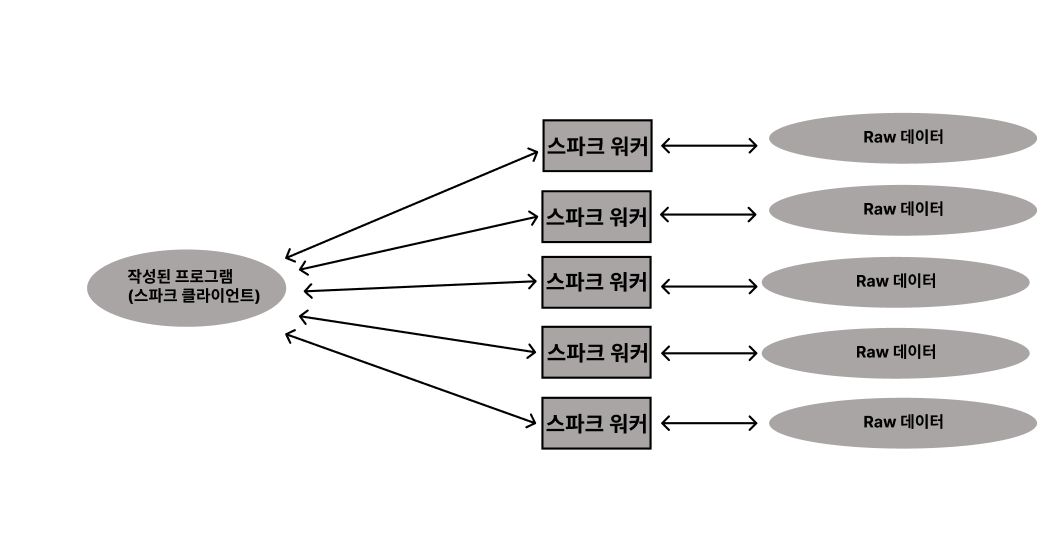

In [2]:
Image("C:/Users/jy990/Study/Streaming data/Image/4.1.PNG")

### Apache Storm

아파치 스톰은 데이터 스트림의 실시간 처리를 위해 설계된 Tuple-at-a-time 프레임워크이다.  

Nimbus를 job tracker로, Superviser를 데이터 노드로 바꾸면 그냥 하둡 클러스터나 스파크 스트리밍과 매우 유사하다. 하둡과 스파크는 Job을 최소 작업 단위로 사용하지만, 스톰은 Topology라는 용어를 사용한다. Job은 작업을 완료하는데 초점을 두지만, Topology는 지속적으로 실행된다는 면이 다르다. 하지만 결국 둘다 worker node에 배포되고 실행되는 것은 동일하다.  

topology가 님버스로 제출되면 님버스는 슈파바이저들에게 토폴로지가 배포되는 방법을 정의한 뒤 각기 다른 작업을 할당해 전체 시스템이 정상 작동하는지 모니터링한다.

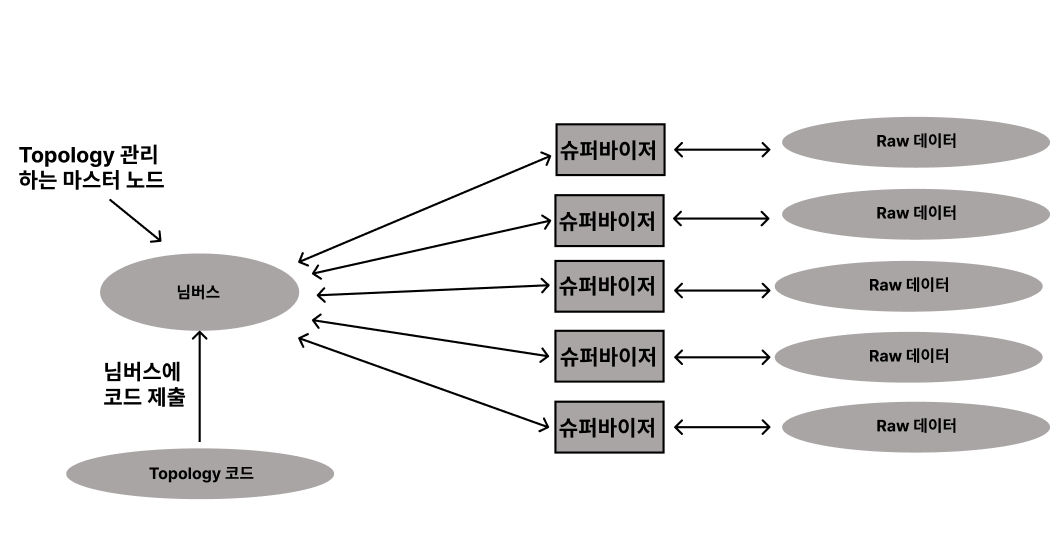

In [3]:
Image("C:/Users/jy990/Study/Streaming data/Image/4.2.PNG")

# Apache Flink

아파치 플링크는 모든 데이터를 스트림으로 간주하고 처리하는 개념을 도입한 프레임워크다.  

플링크로 구성된 어플리케이션은 Stream/Transformation 2가지 요소로 구성된다. Stream은 소스에서 싱크로 데이터가 흐를 때 중간 결과로 사용되고, Transformation은 하나 이상의 Stream을 입력값으로, 하나 이상의 Stream의 출력값을 생성하는 작업이다. 1개 이상의 데이터 소스를 입력값으로 사용하고, 하나 이상의 트랜스포메이션을 포함해 데이터플로우를 만든다.  

마지막으로 싱크를 만들어 처리된 데이터를 저장하고 프로세싱을 마무리한다. 플링크 애플리케이션은 단일 마스터와 워커로 구성된 분산 환경에서 실행된다.

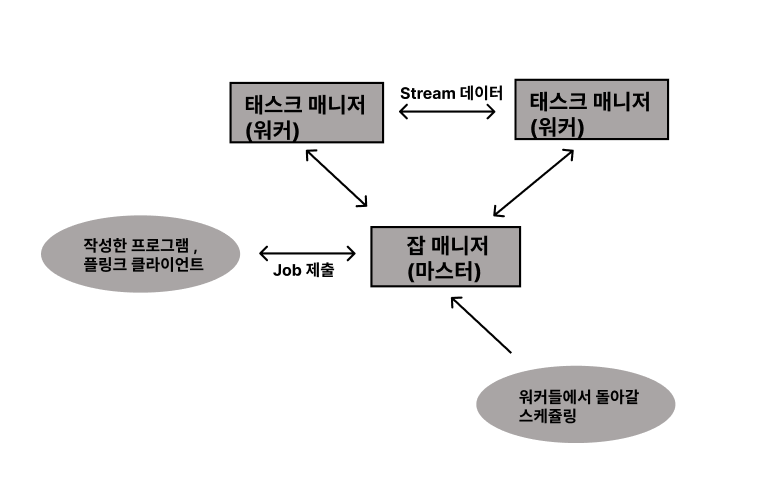

In [4]:
Image("C:/Users/jy990/Study/Streaming data/Image/4.3.PNG")

# Apache Samza

삼자는 단계별 스트림 처리 프레임워크다. 아파치 얀, 아파치 카프카를 기반으로 실행된다.  

얀은 리소스 관리, 잡 스케쥴링/모니터링을 수행하는 크러스터 매니저다. 얀의 리소스 매니저는 다수의 서버로 구성된 클러스터에서 모든 애플리케이션의 리소스(CPU, 메모리, 디스크, 네트워크 등)를 할당하는 역할을 담당한다. 잡 스케쥴링/모니터링은 클러스터에 해당 잡이 ㅣㄹ행 중인 경우에만 동작한다.삼자 태스크들에 대한 모든 입출력은 아파치 카프카를 통해 수행된다.  

아파치 카프카는 메시지 큐 단계에 가장 적합한 기술이고, 앞으로 한번 더 언급될 것이다. 여기서는 스트림 프로세싱을 위해 데이터를 저장하는 저장소로만 이해하면 된다.

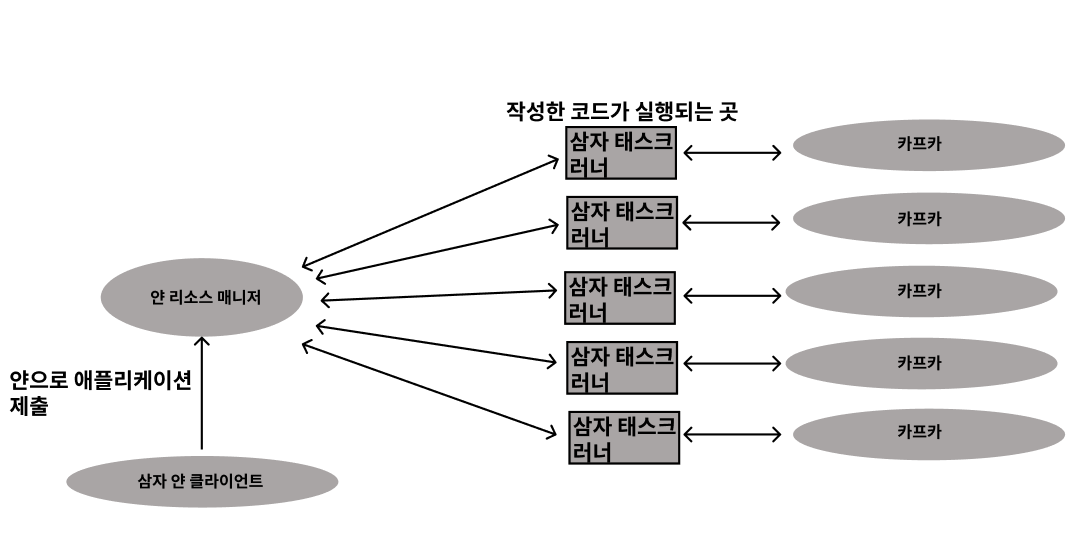

In [5]:
Image("C:/Users/jy990/Study/Streaming data/Image/4.4.PNG")

# 스트림 프로세싱 프레임워크의 핵심기능

적합한 프레임워크를 고르기 위해 고려해야 하는 몇 가지 주요 기능들이 있다.

### 메시지 전달 시맨틱

3장에서는 메시지 큐 단계에서 사용되는 Producer, Broker, Consumer와 관련된 메시지 전달 시맨틱을 알아보았다. 이번에는 메시지 큐 단계의 Consumer 역할을 하는 분석 단계에서 메시지 전달 시맨틱이 어떻게 적용되는지 보자. 함축된 의미가 약간 달라진다.  

우선 스트림 데이터는 스트림 프로세서를 여러 번 거치는 흐름을 갖는다.

- **최대 1번** : 일부 메시지 유실 가능성 있음. 절대 데이터 중복처리 없음  

- **적어도 1번** : 메시지 유실 가능성 없음. 일부 데이터 중복처리 가능성 있음  

- **정확히 1번** : 모든 메시지 유실x. 반드시 1번 처리  


*최대 1번* 처리를 하면 스트림 프로세서에 메시지가 2개 들어가지만 하나만 출력되는 등의 문제가 발생할 수 있다. 하지만 구현 가능한 가장 간단한 스트림 처리이다.  

*적어도 1번* 처리는 스트리밍 매니저가 메시지를 추적하다가 처리되지 않았다고 판단하면 메시지가 재전송된다. 그래서 여러 번 전달될 수 있다. 그러므로 스트리밍 잡이 idempotent하게 동작해야 한다. 대신 추적 때문에 복잡성이 크게 증가한다. idempotent란 동일 순서, 동일 입력을 받는 2개의 스트림 프로세서는 반드시 동일 결과를 추출함을 의미한다.  

*정확히 1번* 처리는 모든 메시지 정보를 보관하고 탐지하고 걸러내야 해서 복잡성이 더 크게 증가한다. 중복 메시지가 응답할 필요가 없고 처리된 후에 성공/실패로 응답하기만 하면 된다. idempotent하게 작동하면 더 좋다  

비즈니스 요구사항에 따라 어떤 시맨틱을 사용할건지 다르게 해야 한다. 예를 들어 터빈 엔진이 어떻게 동작하는지 지속적으로 분석해 고장이 발생할 시기를 예측하고 사전에 유지보수를 진행하고자 한다고 하자. 터빈이 매시간 1TB의 데이터를 생산한다면, 그걸 전부 모니터링 해야할까? 이런 고민이 필요하다.

### 상태 관리

현재 처리 중인 메시지가 외부 데이터, 이전에 처리된 미시지와 연동될 때 분석 알고리즘은 매우 복잡해진다. 이때 상태를 유지하는 기능이 필요하다. 데이터 유실은 간단한 문제가 아니며, 상태를 어떻게 관리해야할지에 대한 고민이 필요하다.  

인메모리 활용 방법에서부터 복제 기반 쿼리 영구 저장소를 활용하는 방법까지 여러 선택지가 있다.  

복잡도를 낮추면서 데이터 상태를 안전하게 유지하는 방법 중 하나는 마지막으로 처리한 결과 데이터를 저장하는 것이다.  

복제 기반 쿼리 영구 저장소는 다양한 데이터 스트림과 결합 활용할 수 있기 때문에 이런 프레임워크는 더 다양하고 어려운 상황도 대응이 가능하다. 

### 장애 허용 설계

현실에서 장애는 언제 발생하는지도 중요하다. 스트림 프레임워크는 장애 허용 설계가 반영되어 있어서 장애 발생해도 계속 프로세싱할 수 있다.  

입력/출력 저장소에 장애가 발생하더라도 스트리밍 프레임워크에 장애가 발생하지 않는 것이 중요하다. 다뤄야할 문제는 아래와 같다.  

**(1) 데이터 유실** : 네트워크에서의 유실, 스트림 프로세서의 장애, 메모리 데이터 유실 등  

**(2) 리소스 관리 장애** : 스트리밍 매니저/애플리케이션 드라이버가 있는 경우 드라이버의 장애  



장애를 다루기 위한 모든 기술은 복제와 조정을 기반으로 한다. 스트림 매니저가 현재 계산 중인 데이터 상태를 다른 스트림 프로세서로 복제하는 것이 일반적이다. 즉 장애 복구를 위해 복제된 데이터를 활용한다. 일반적으로 사전에 정의된 k개의 동시 장애 개수를 지정해 여기까지는 컨트롤을 하는 **k-내결함성** 시스템을 사용한다.  

스트림 시스템에서 사용하는 첫 번째 방식은 상태 머신이다. 독립된 노드에서 잡을 복제하고 동일 입력을 모든 노드에 동일 순서로 전송에 복제 데이터를 조정한다. 이는 자원이 많이 들지만 빠르게 장애 복구가 가능해 운영 중단이 발생하지 않는 것이 장점이다. 지연 시간이 짧아야 하는 침입 감지 시스템 등에서 이런 방법을 쓴다.  

두 번째는 롤백 복구 방식이다. 롤백 복구는 스트림 프로세서가 주기적으로 체크포인트를 찍어 다른 비휘발성 저장소에 저장한다. 그리고 각 체크 포인트 사이에 계산된 데이터만 추적한다. 디스크는 대기 시간이 상대적으로 길어서 지연이 발생할 수 있다.